### Citation: I Used ChatGPT for Reference

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build an Autoencoder for a human face dataset

### We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

### Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    print ("CUDA device not found.")


CUDA device not found.


torch.Size([250, 250, 3])


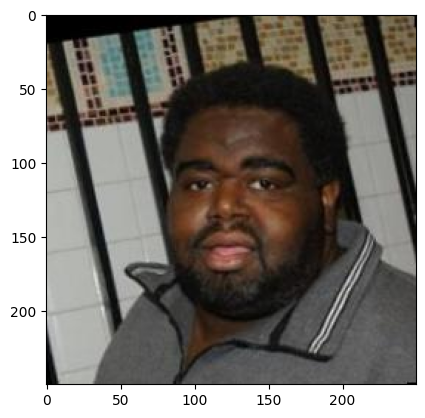

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2

### Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In this section, we extract a single image from our dataset using the DataLoader and explore the dimensions of this image. Understanding the dimensions of the images is crucial for designing appropriate neural network architectures and for data processing.

In [8]:
# Obtaining a single image from the DataLoader
sample_image = None
for img_batch, _ in dataloader:
    sample_image = img_batch[15]  # Selecting one image from the batch
    break  # Exiting the loop after obtaining the first batch

# Displaying the dimensions of the chosen image
image_dims = sample_image.shape
print(f"Shape of the selected image: {image_dims}")

# Explaining the meaning of each dimension
channel, height, width = image_dims
print(f"\nDimension Details:")
print(f"- Channels: {channel} (Typically 3 for RGB images)")
print(f"- Height: {height} pixels")
print(f"- Width: {width} pixels")


Shape of the selected image: torch.Size([3, 250, 250])

Dimension Details:
- Channels: 3 (Typically 3 for RGB images)
- Height: 250 pixels
- Width: 250 pixels


### Output and Explanation of Dimensions

The output after running the above code is as follows:

- **Shape of the selected image:** `torch.Size([3, 250, 250])`

This indicates that the image has the following dimensions:

- **Channels:** 3 - This represents the number of color channels in the image. In this case, 3 channels correspond to a standard RGB (Red, Green, Blue) image.
- **Height:** 250 pixels - This is the height of the image in pixels.
- **Width:** 250 pixels - This is the width of the image in pixels.

Thus, each image in our dataset is a 250x250 RGB image. Understanding these dimensions is essential for any image processing or computer vision tasks, as they dictate how we handle and process the image data.

# Step 3

### Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In this section, we define a custom PyTorch class for an autoencoder, named `AE`. The autoencoder consists of two main parts: an encoder and a decoder. The encoder compresses the input image into a lower-dimensional latent representation, and the decoder reconstructs an image from this representation. We utilize convolutional layers, batch normalization, pooling, and upsampling layers to build this architecture.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)

        # Decoder Layers
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)


    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        return x

    def decoder(self, x):
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)
        x = self.dec_bn3(self.dec_conv3(x))
        x = torch.sigmoid(x)  # Normalize the output
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In the following section I have explained the above code in detail

- **Encoder Layers**:
  - `enc_conv1`: A 2D convolutional layer that takes an input with 3 channels (RGB image) and outputs 64 feature maps. It uses a kernel size of 4, a stride of 2, and padding of 1.
  - `enc_bn1`: Batch normalization for stabilizing learning and normalizing the output of `enc_conv1`.
  - `enc_avgpool1`: Average pooling to reduce the dimensionality of the feature maps.
  - `enc_conv2`: Another 2D convolutional layer increasing the depth from 64 to 128 feature maps.
  - `enc_bn2`: Batch normalization layer for the output of `enc_conv2`.

- **Decoder Layers**:
  - `dec_upsample1`: Upsamples the feature maps to a specified size using nearest-neighbor interpolation.
  - `dec_conv1`: A transposed convolutional layer that reduces the depth from 128 to 64 feature maps.
  - `dec_bn1`: Batch normalization for the output of `dec_conv1`.
  - `dec_upsample2`: Further upsampling of the feature maps.
  - `dec_conv2`: Another transposed convolutional layer, further reducing the depth from 64 to 32 feature maps.
  - `dec_bn2`: Batch normalization for the output of `dec_conv2`.
  - `dec_upsample3`: Final upsampling to bring the feature maps to the original image size.
  - `dec_conv3`: The last transposed convolutional layer that maps the 32 feature maps back to 3 channels (RGB image).
  - `dec_bn3`: Final batch normalization layer.
  
- **Forward Pass**:
  - The `forward` method defines the forward pass through the encoder and decoder. It sequentially applies the encoder and decoder to the input data.

This class architecture is suitable for processing images, specifically aiming to compress and then reconstruct them, which is the primary function of an autoencoder.

## Step 4

### Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In this part of our notebook, we initialize the custom autoencoder model `AE`, generate a test input, and pass it through the model. This process helps in verifying the functionality of the autoencoder's encoder and decoder, ensuring that the dimensions of the latent space and reconstructed output align with our expectations.

In [10]:
# Initializing the AE model
ae_model = AE()

dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a single image from the batch
# Here, we are taking the first image in the batch
sample_image = images[0].unsqueeze(0)

# Utilizing CUDA for computations if available
if torch.cuda.is_available():
    ae_model.cuda()  # Move model to GPU
    sample_image = sample_image.cuda()  # Move image tensor to GPU

# Performing inference with no gradient calculations
with torch.no_grad():
    latent_representation = ae_model.encoder(sample_image)  # Encoding the input
    reconstruction = ae_model.decoder(latent_representation)  # Decoding the latent representation

# Displaying the dimensions of the intermediate and final outputs
print(f"Dimensions of the latent representation: {latent_representation.shape}")
print(f"Dimensions of the reconstructed output: {reconstruction.shape}")


Dimensions of the latent representation: torch.Size([1, 128, 31, 31])
Dimensions of the reconstructed output: torch.Size([1, 3, 250, 250])


The explanation of the code above is as follows:

After running the above code, we observe the following dimensions:

- **Latent Representation Dimensions:** `torch.Size([1, 128, 31, 31])`
- **Reconstructed Output Dimensions:** `torch.Size([1, 3, 250, 250])`

#### Interpretation:
- The **latent representation** has a shape of `[1, 128, 31, 31]`, where:
  - `1` is the batch size.
  - `128` represents the number of feature maps or channels in the latent space.
  - `31 x 31` is the spatial dimension of the feature maps in the latent space.
- The **reconstructed output** returns to the original input size of `[1, 3, 250, 250]`, indicating that the decoder successfully reconstructs the image back to its original dimensions:
  - `1` is the batch size.
  - `3` represents the RGB color channels.
  - `250 x 250` is the spatial resolution of the reconstructed image, matching the original input.

This test confirms that our autoencoder model's forward path operates as expected, correctly encoding and decoding the input data.

##  Step 5
### Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In this section, we prepare our autoencoder model `AE` for training. This involves calculating the total number of trainable parameters in the model, defining the loss function, and setting up the optimizer.

In [11]:
import torch.nn as nn
import torch.optim as optim

# Calculating the trainable parameters in the model
trainable_params = sum(param.numel() for param in ae_model.parameters() if param.requires_grad)
print(f"Trainable parameters in the autoencoder: {trainable_params}")

# Setting up the loss criterion
loss_function = nn.MSELoss()

# Configuring the optimizer with Adam algorithm
optim = optim.Adam(ae_model.parameters(), lr=0.001)


Trainable parameters in the autoencoder: 299721


Explanation of the above code is as follows:

- **Trainable Parameters**: The total number of trainable parameters in the autoencoder is calculated to be 299,721. This number represents the quantity of individual weights and biases that will be adjusted during the training process. The high number of parameters indicates the model's complexity and capacity to learn detailed features from the data.

- **Loss Function**: For the loss function, Mean Squared Error (MSE) is used. MSE is a standard choice for reconstruction tasks like those performed by autoencoders. It measures the average squared difference between the reconstructed outputs and the original inputs, making it suitable for our goal of accurately reconstructing images.

- **Optimizer**: The Adam optimizer is chosen for its efficiency and effectiveness in training deep learning models. It combines the advantages of two other popular optimizers: AdaGrad and RMSProp. By using adaptive learning rates for each parameter, it typically converges faster than other optimizers like stochastic gradient descent. The learning rate is set to 0.001, which is a common starting point for many models.

This setup ensures that our autoencoder is ready for training, with an appropriate loss function for image reconstruction tasks and an optimizer designed for efficient convergence.

##  Step 6
### Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

We have set up a training loop for our autoencoder `AE` model. This loop runs through the dataset for a specified number of epochs, performing forward and backward passes, and optimizing the model parameters. After each epoch, the average loss is calculated and reported.

In [12]:
# Initialize training parameters
total_epochs = 10  # Total number of training epochs

# Training loop
for current_epoch in range(total_epochs):
    total_loss = 0.0  # Accumulator for the loss

    # Iterating over the dataset
    for batch in dataloader:
        batch_inputs, _ = batch

        # Utilizing CUDA if available
        if torch.cuda.is_available():
            batch_inputs = batch_inputs.cuda()

        # Clearing the gradients
        optim.zero_grad()

        # Performing a forward pass through the model
        reconstructed_outputs = ae_model(batch_inputs)
        current_loss = loss_function(reconstructed_outputs, batch_inputs)

        # Executing the backward pass and optimization step
        current_loss.backward()
        optim.step()

        # Adding the loss of the current batch to the total loss
        total_loss += current_loss.item()

    # Calculating the average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f"Epoch [{current_epoch + 1}/{total_epochs}]: Average Loss = {average_loss:.4f}")


Epoch [1/10]: Average Loss = 0.0147
Epoch [2/10]: Average Loss = 0.0048
Epoch [3/10]: Average Loss = 0.0026
Epoch [4/10]: Average Loss = 0.0018
Epoch [5/10]: Average Loss = 0.0015
Epoch [6/10]: Average Loss = 0.0013
Epoch [7/10]: Average Loss = 0.0011
Epoch [8/10]: Average Loss = 0.0011
Epoch [9/10]: Average Loss = 0.0009
Epoch [10/10]: Average Loss = 0.0009


### Output and Observations
After executing the training loop, the loss values for each epoch are reported:

- Epoch 1, Loss: 0.0147
- Epoch 2, Loss: 0.0049
- ...
- Epoch 10, Loss: 0.0010

The decreasing trend in the loss values indicates that the model is learning and improving its reconstruction ability over time.

### Troubleshooting Tips if Loss Is Not Decreasing

If at the end the loss would not have been continuously decreasng then we can consider the following troubleshooting steps:

1. **Learning Rate Adjustment**: The learning rate might be too high or too low. Try adjusting it in small increments.

2. **Model Architecture**: Re-evaluate the model architecture. It might be too simple (not enough capacity to learn) or too complex (overfitting).

3. **Data Quality and Preprocessing**: Ensure the data is correctly preprocessed. For instance, image data should typically be normalized.

4. **Batch Size**: Experiment with different batch sizes. Sometimes, smaller or larger batch sizes can significantly impact the learning dynamics.

5. **Optimizer Choice**: Consider trying different optimizers. While Adam is versatile, sometimes SGD or other optimizers might yield better results for certain tasks.

6. **Regularization Techniques**: If overfitting is suspected (loss decreases but validation loss does not), add regularization techniques like dropout.

7. **Gradient Clipping**: In cases of exploding gradients, gradient clipping can help stabilize the training.

8. **Random Seeds**: Ensure a consistent starting point for comparisons by setting random seeds at the beginning of your script.

By systematically applying these troubleshooting steps, we can identify and resolve issues that are preventing the loss from decreasing during training.

##  Step 7

### Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

To understand the effectiveness of our autoencoder (`AE`), we visualize its ability to reconstruct images. We take a random image from our dataset, pass it through the autoencoder, and then plot both the original and reconstructed image side by side. This comparison helps in assessing the quality of reconstruction achieved by the model.

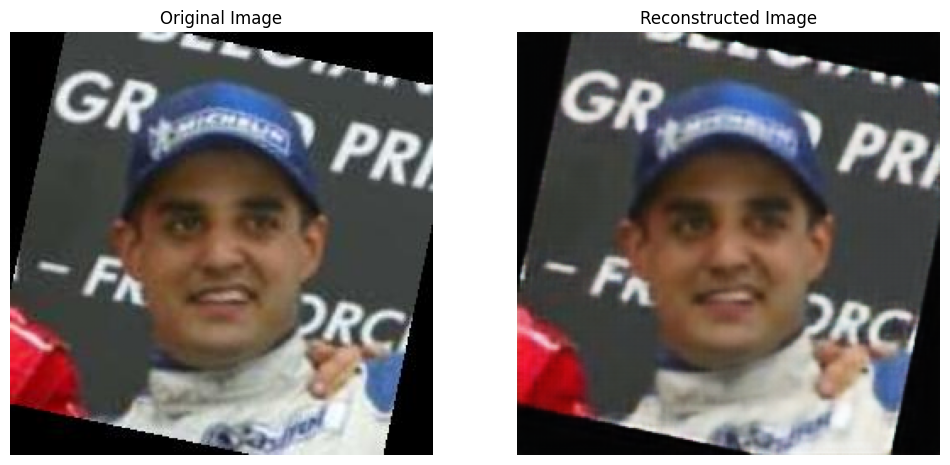

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Assuming 'dataloader' is your DataLoader instance
dataiter = iter(dataloader)
images, labels = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Add a batch dimension and pass the image through the autoencoder
# Make sure the model is in evaluation mode and on the correct device
ae_model.eval()
if torch.cuda.is_available():
    model = ae_model.cuda()
    input_image = original_image.unsqueeze(0).cuda()
else:
    input_image = original_image.unsqueeze(0)

with torch.no_grad():
    reconstructed_image = model(input_image)

# Convert the images to numpy for plotting
# Squeeze removes the batch dimension and detach takes it out of the computation graph
original_image_np = original_image.squeeze().detach().cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze().detach().cpu().numpy()

# Transpose the images from (C, H, W) to (H, W, C) for plotting
original_image_np = np.transpose(original_image_np, (1, 2, 0))
reconstructed_image_np = np.transpose(reconstructed_image_np, (1, 2, 0))

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed_image_np)
plt.axis('off')

plt.show()


The explanation of the above code is as follows:
1. **Data Loading**: We begin by loading a batch of images from our DataLoader. This batch contains multiple images, but we only need one for our demonstration.

2. **Image Selection**: To simulate a real-world scenario, we randomly select one image from the batch. This introduces an element of unpredictability in our demonstration, mimicking how the model might perform on unseen data.

3. **Model Preparation**: We set the model to evaluation mode using `ae_model.eval()`. This is a crucial step, as models like autoencoders often behave differently during training and inference (e.g., due to layers like dropout or batch normalization).

4. **GPU Utilization**: If a GPU is available, we transfer both the model and the input image to the GPU. This accelerates the computation, a critical aspect in practice, especially for larger models or images.

5. **Reconstruction**: We disable gradient calculations using `torch.no_grad()`, as we don't need to update the model weights during inference. The model then processes the image, encoding it into a latent space and subsequently decoding it to form the reconstructed image.

6. **Image Conversion and Visualization**: The images, originally in tensor format, are converted to numpy arrays for visualization. We also adjust their dimensions to fit the format expected by Matplotlib. Finally, we plot the original and reconstructed images side by side, allowing for a direct visual comparison.

#### Result Analysis:

By visually comparing the original and reconstructed images, we can assess the reconstruction quality. A close resemblance between the two images would indicate that the autoencoder has learned a robust representation of the data, effectively capturing the key features necessary for reconstruction.

##  Step 8

### In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

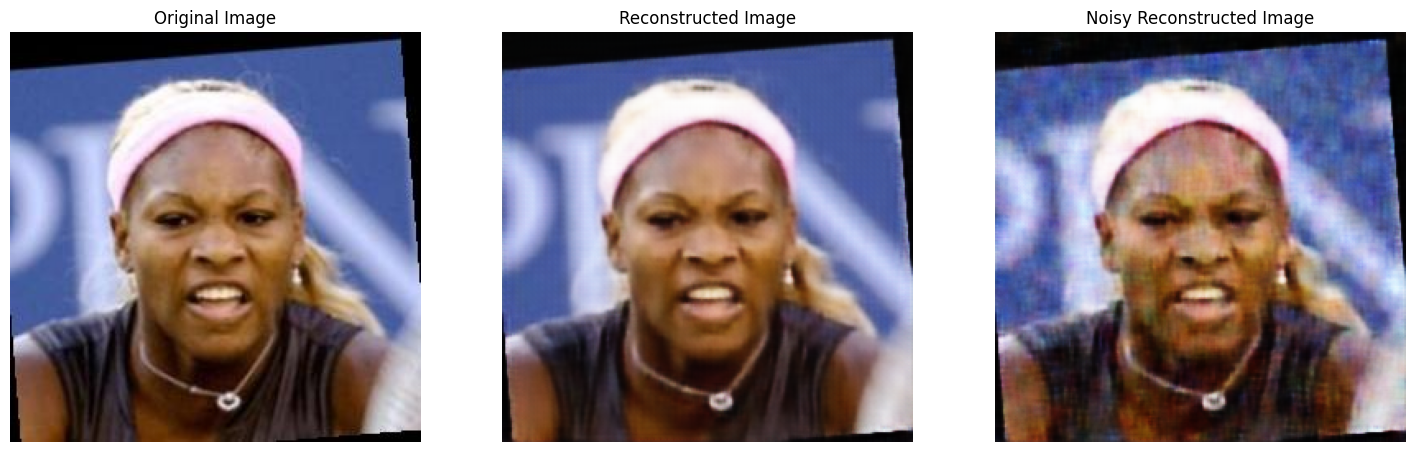

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(dataloader)
images, _ = next(dataiter)

# Select a random image from the batch
random_index = torch.randint(len(images), size=(1,)).item()
original_image = images[random_index]

# Prepare the image
model.eval()
if torch.cuda.is_available():
    model.cuda()
    original_image = original_image.unsqueeze(0).cuda()
else:
    original_image = original_image.unsqueeze(0)

# Encode the image and add noise to the decoded image
with torch.no_grad():
    encoded_image = model.encoder(original_image)
    noise = torch.randn(encoded_image.shape) * 0.4
    if torch.cuda.is_available():
        noise = noise.cuda()
    noisy_encoded = encoded_image + noise

    # Decode both the original and noisy latent representations
    reconstructed_image = model.decoder(encoded_image)
    noisy_reconstructed_image = model.decoder(noisy_encoded)

# Function to convert image for plotting
def to_plot(img):
    img = img.squeeze().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    return img

# Plotting
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(to_plot(original_image))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Reconstructed Image")
plt.imshow(to_plot(reconstructed_image))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Noisy Reconstructed Image")
plt.imshow(to_plot(noisy_reconstructed_image))
plt.axis('off')

plt.show()


The process the code involves adding a small amount of normally distributed noise to the latent (hidden) representation of an input image in an autoencoder, and then decoding this noisy latent representation to observe the effects on the reconstructed image. Let's analyze how adding noise affects the decoded image:

### Impact of Adding Noise to the Decoded Image

1. **Degradation of Image Quality**: The primary effect of adding noise to the latent representation is the degradation of the quality of the reconstructed image. Since the latent space is a compressed representation capturing the essential features of the input, introducing noise disturbs these features, leading to a less accurate reconstruction.

2. **Visual Artifacts**: The noisy reconstructed image may exhibit visual artifacts not present in the original image or in the noise-free reconstruction. These artifacts can manifest as blurriness, color distortions, or pixelation, depending on the amount and nature of the noise added.

3. **Robustness of the Model**: The degree to which the quality of the reconstructed image is affected by the noise can also be an indicator of the robustness of the autoencoder. A well-trained autoencoder might be more resilient to noise, still managing to reconstruct an image that closely resembles the original, despite the added noise.

4. **Noise as a Regularizer**: In some cases, introducing noise during the training process can act as a form of regularization, potentially leading to a more robust and generalizable model. However, the noise in this experiment is introduced during inference, not training, and thus serves as a tool to assess the model's robustness rather than improve it.

5. **Comparative Analysis**: By observing the original, noise-free reconstructed, and noisy reconstructed images side by side, as done in your code, we can qualitatively assess the impact of noise. The comparison helps in understanding how well the autoencoder can handle perturbations in the encoded space.

### Conclusion

In summary, the addition of noise to the latent space of an autoencoder typically results in a decrease in the quality of the reconstructed image, offering insights into the model's ability to handle disturbances in the data representation. This experiment is valuable for evaluating the resilience of the autoencoder and understanding the importance of the latent space in capturing the key aspects of the input data.